In [1]:
%matplotlib inline
%run '../../../analysis/bin/notebook_utils.py'
%run '../../../analysis/bin/plot_utilization.py'
import matplotlib.ticker as mticker

In [2]:
suds = ['re.session.login2.hrlee.018516.0032']

In [3]:
sdir = "./"

In [4]:
sids = [sdir+s for s in suds]

In [5]:
%%capture capt

ss = {}
for sid in suds:
    sp = sdir+sid
    ss[sid] = {'s': ra.Session(sp, 'radical.pilot')}
    ss[sid].update({'p': ss[sid]['s'].filter(etype='pilot'   , inplace=False),
                    'u': ss[sid]['s'].filter(etype='unit'    , inplace=False),
                    't': ss[sid]['s'].filter(etype='task'    , inplace=False),
                    'w': ss[sid]['s'].filter(etype='pipeline', inplace=False)})
                    

In [6]:
for sid in suds:
    ss[sid].update({'sid'   : ss[sid]['s'].uid,
                    'pid'   : ss[sid]['p'].list('uid'),
                    'npilot': len(ss[sid]['p'].get()),
                    'lm'    : ss[sid]['s'].get(etype='pilot')[0].cfg['agent_launch_method'],
                    'npact' : len(ss[sid]['p'].timestamps(state='PMGR_ACTIVE')),
                    'nunit' : len(ss[sid]['u'].get()),
                    'nudone': len(ss[sid]['u'].timestamps(state='DONE')),
                    'nufail': len(ss[sid]['u'].timestamps(state='FAILED'))})
    ss[sid].update({'pres'  : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['resource'],
                    'ncores': ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['cores'],
                    'ngpus' : ss[sid]['p'].get(uid=ss[sid]['pid'])[0].description['gpus']})                  
    ss[sid].update({'nnodes': ss[sid]['ngpus']/6})
    

In [7]:
info = []
for sid in suds:
    info.append({'session'  : sid,
                 'resource' : ss[sid]['pres'],
                 'pilot_lm' : ss[sid]['lm'], 
                 'pilots'   : ss[sid]['npilot'],
                 'ps_active': ss[sid]['npact'],
                 'cores'    : ss[sid]['ncores']/4, 
                 'gpus'     : ss[sid]['ngpus'], 
                 'nodes'    : ss[sid]['nnodes'], 
                 'tasks'    : ss[sid]['nunit'], 
                 'ts_done'  : ss[sid]['nudone'],  
                 'ts_failed': ss[sid]['nufail']})

df_info = pd.DataFrame(info) 
df_info

,session,resource,pilot_lm,pilots,ps_active,cores,gpus,nodes,tasks,ts_done,ts_failed
0,re.session.login2.hrlee.018516.0032,ornl.summit,JSRUN,1,1,840.0,120,20.0,241,121,120


In [8]:
metrics_default = [

        # pilot overheads (global)
        ['Pilot Startup',     ['boot', 'setup_1']],
        ['Pilot Termination', ['term' ]],

        # derived pilot durations
        ['Agent Nodes',       ['agent']],
        ['Warmup',            ['warm' ]],
        ['Draining',          ['drain']],
        ['Idle',              ['idle' ]],

        # unit durations
        ['Prepare Exec',      ['exec_queue', 'exec_prep']],
        ['Exec RP',           ['exec_rp', 'exec_sh', 'term_sh', 'term_rp']],
        ['Exec Cmd',          ['exec_cmd']],
        ['Unschedule',        ['unschedule']],
]

In [9]:
# %%capture capt

# Remove cache to avoid reloading errors
! rm -r ~/.radical/analytics

sobjs = ra.Experiment(sids, stype='radical.pilot')
provided, consumed, stats_abs, stats_rel, info = sobjs.utilization(metrics=metrics_default)

cache read failed: [Errno 2] No such file or directory: '/Users/mturilli/.radical/analytics/cache//re.session.login2.hrlee.018516.0032.pickle'


In [10]:
# x-axis labels
xkeys = list()

# get the numbers we actually want to plot
for session in sobjs.sessions:

    n_units = len(session.get(etype='unit'))
    
    p_size = 0
    for pilot in session.get(etype='pilot'):
        p_size += pilot.description['cores']

    xkeys.append('%s / %s' % (n_units, p_size))

# zero points to zero the axes of the plot.
p_zeros = {}
for session in sobjs.sessions:
    for pilot in session.get(etype='pilot'):
        p_zeros[session.uid] = pilot.timestamps(event={ru.EVENT: 'bootstrap_0_start'})[0]

def update_ticks(x, pos):
    return int(x/168)
    

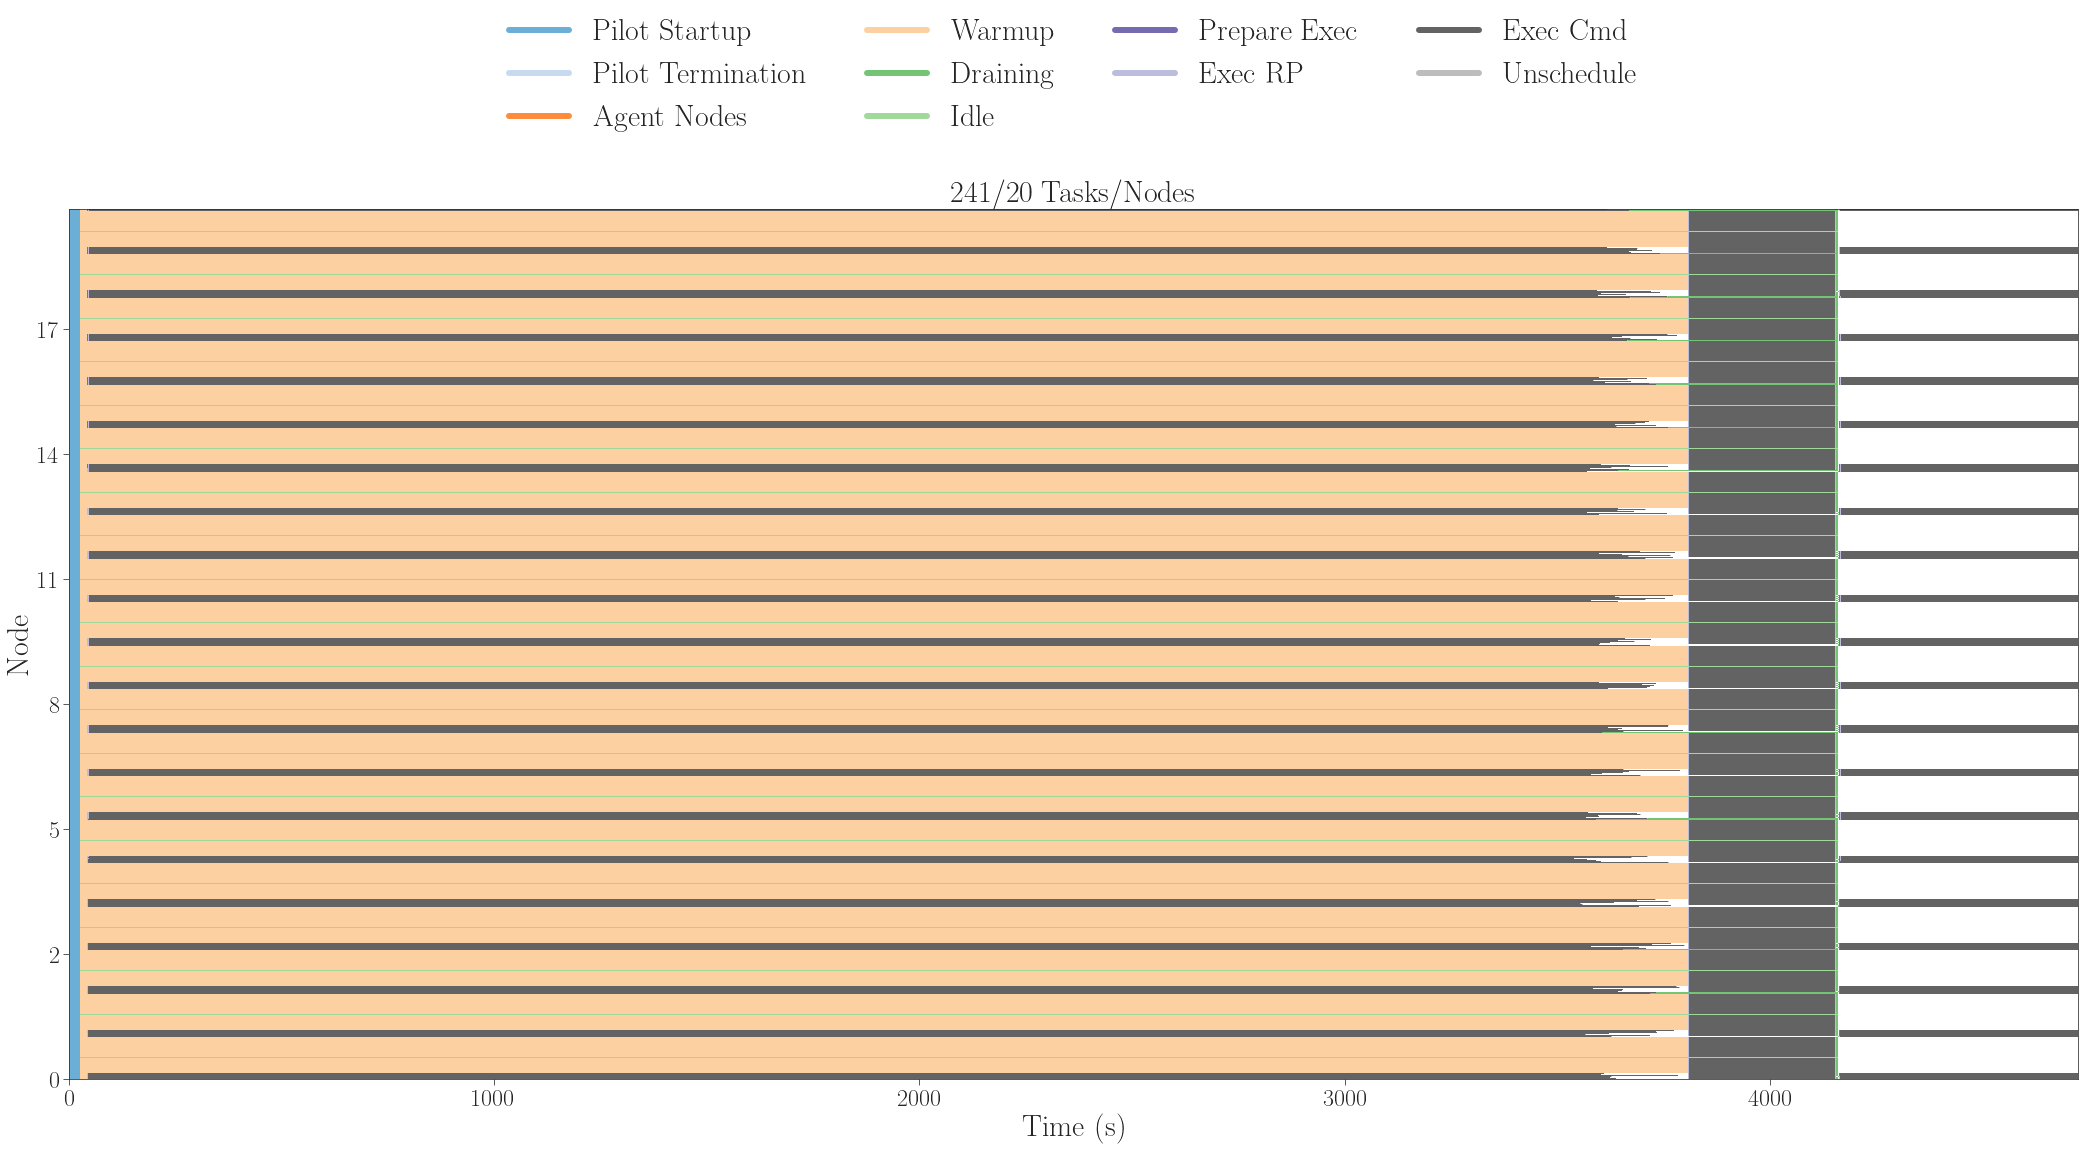

In [11]:
skip = []
nsids = len(suds) - len(skip)

fwidth = 36
fhight = 16
fig, axarr = plt.subplots(1, nsids, sharex='col', figsize=(fwidth, fhight))

i = 0
j = 'a'
for sid in suds:
    
    if sid in skip:
        continue

    if nsids > 1:
        ax = axarr[i]
        ax.set_xlabel('(%s)' % j, labelpad=45)
    else:
        ax = axarr

    cmap = mpl.cm.get_cmap('tab20c')

    step = 1.0 / (len(metrics_default) + 1)
    this = step / 1.0
    legend = list()

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    
    ax.set_title('%s/%s Tasks/Nodes' % (ss[sid]['nunit'], int(ss[sid]['nnodes'])), fontdict={'fontsize': 30})

    for metric in metrics_default:

        color = cmap(this)
        this += step

        legend.append(mpl.lines.Line2D([0], [0], color=color, lw=6))

        if isinstance(metric, list):
            name = metric[0]
            parts = metric[1]
        else:
            name = metric
            parts = [metric]

        for part in parts:
            for uid in consumed[sid][part]:
                for block in consumed[sid][part][uid]:
                    orig_x = block[0] - p_zeros[sid]
                    orig_y = block[2] - 0.5
                    width = block[1] - block[0]
                    height = block[3] - block[2] + 1.0

                    if x_min is None:
                        x_min = orig_x
                    if x_max is None:
                        x_max = orig_x + width
                    if y_min is None:
                        y_min = orig_x
                    if y_max is None:
                        y_max = orig_x + height

                    x_min = min(x_min, orig_x)
                    y_min = min(y_min, orig_y)
                    x_max = max(x_max, orig_x + width)
                    y_max = max(y_max, orig_y + height)

                    patch = mpl.patches.Rectangle((orig_x, orig_y),
                                                  width, height,
                                                  facecolor=color,
                                                  edgecolor='black',
                                                  fill=True, lw=0.0)
                    ax.add_patch(patch)

    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    ax.set_xlabel('Time (s)', fontsize=30)
    ax.set_ylabel('Node', fontsize=30)
    
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    i = i+1
    j = chr(ord(j) + 1)
    
# Add legend
ax.legend(legend, [m[0] for m in metrics_default], loc='upper center',
          fontsize=30, ncol=4, bbox_to_anchor=(0.5, 1.25))

# plt.savefig('figures/ru.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('figures/ru.png', dpi=300, bbox_inches='tight')